In [38]:
# -------------------------------
# Cell 1: Imports & Device
# -------------------------------
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

from pathlib import Path
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import cv2
# Grad-CAM
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask

# SHAP
import shap

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")


Using device: cpu


In [39]:
# -------------------------------
# Cell 2: Load Dataset
# -------------------------------
NUM_CLASSES = 35
DATA_DIR = Path("dataset")
BATCH_SIZE = 16

val_clean_dataset = ImageFolder(DATA_DIR/"val/clean", transform=transforms.Compose([
    transforms.Resize((250,250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
]))
val_clean_loader = DataLoader(val_clean_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = val_clean_dataset.classes


In [40]:
# -------------------------------
# Cell 3: Load Fine-tuned Model
# -------------------------------
model = models.efficientnet_b0(pretrained=False)
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(in_features, NUM_CLASSES)
)

model.load_state_dict(torch.load("best_model.pth", map_location=device))
model = model.to(device)
model.eval()
print("Fine-tuned model loaded for XAI.")


Fine-tuned model loaded for XAI.


In [41]:
# -------------------------------
# Cell 4: Grad-CAM Setup
# -------------------------------
# SmoothGradCAM++ for better heatmaps
cam_extractor = SmoothGradCAMpp(model)

def generate_gradcam(img_tensor, target_class):
    """
    Generate Grad-CAM heatmap for a single image tensor.
    img_tensor: [1, C, H, W]
    target_class: int
    """
    img_tensor = img_tensor.to(device)
    out = model(img_tensor)

    # Grad-CAM
    activation_map = cam_extractor(target_class, out)  # shape [1,H,W]
    
    # Convert to numpy, normalize, squeeze channel
    cam_np = activation_map[0].squeeze(0).cpu().numpy()  # [H, W]
    cam_np -= cam_np.min()
    if cam_np.max() > 0:
        cam_np /= cam_np.max()
    cam_np = (cam_np * 255).astype(np.uint8)

    # Convert to PIL and resize
    cam_img = Image.fromarray(cam_np).resize((img_tensor.shape[3], img_tensor.shape[2]))

    # Original image
    img_pil = transforms.ToPILImage()(img_tensor.squeeze(0).cpu())

    # Overlay
    result = overlay_mask(img_pil, cam_img, alpha=0.5)
    return result


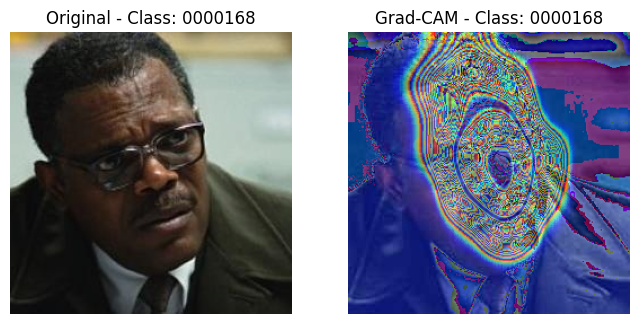

In [42]:
# -------------------------------
# Cell 5: Grad-CAM Example
# -------------------------------
img, label = next(iter(val_clean_loader))

# Original image (unnormalized for visualization)
orig_img = img[2].cpu().permute(1, 2, 0).numpy()
orig_img = np.clip(orig_img * np.array([0.229, 0.224, 0.225]) + 
                   np.array([0.485, 0.456, 0.406]), 0, 1)

# Grad-CAM overlay
gradcam_img = generate_gradcam(img[2:3], label[0].item())

# Plot side by side
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(orig_img)
plt.title(f"Original - Class: {class_names[label[0]]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(gradcam_img)
plt.title(f"Grad-CAM - Class: {class_names[label[0]]}")
plt.axis("off")

plt.show()


In [48]:
# -------------------------------
# Cell 6: Class-wise Average Grad-CAMs
# -------------------------------
from collections import defaultdict
import random

def compute_classwise_avg_heatmaps(model, dataloader, cam_extractor, num_classes=NUM_CLASSES, max_images_per_class=10):
    """
    Compute class-wise average Grad-CAM heatmaps for global explanations.
    Limits to `max_images_per_class` per class for speed.
    """
    model.eval()
    avg_heatmaps = defaultdict(list)
    class_counts = defaultdict(int)
    
    for imgs, labels in tqdm(dataloader, desc="Computing Grad-CAMs"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        
        for img, label, pred in zip(imgs, labels, preds):
            if label != pred:
                continue  # only use correctly classified images
            
            if class_counts[label.item()] >= max_images_per_class:
                continue  # skip if we have enough samples
            
            # Generate Grad-CAM
            heatmap = cam_extractor(pred.item(), outputs)[0].squeeze(0).cpu().numpy()
            heatmap -= heatmap.min()
            if heatmap.max() > 0:
                heatmap /= heatmap.max()
            
            avg_heatmaps[label.item()].append(heatmap)
            class_counts[label.item()] += 1

        # Stop early if all classes reached max_images_per_class
        if all([class_counts[c] >= max_images_per_class for c in range(num_classes)]):
            break
    
    # Compute average heatmap per class
    for cls in avg_heatmaps:
        avg_heatmaps[cls] = np.mean(avg_heatmaps[cls], axis=0)
    
    return avg_heatmaps

# Example usage
max_images_per_class = 3  # tweak for speed
avg_heatmaps = compute_classwise_avg_heatmaps(model, val_clean_loader, cam_extractor, max_images_per_class=max_images_per_class)



Computing Grad-CAMs:  97%|█████████▋| 170/175 [15:26<00:27,  5.45s/it]


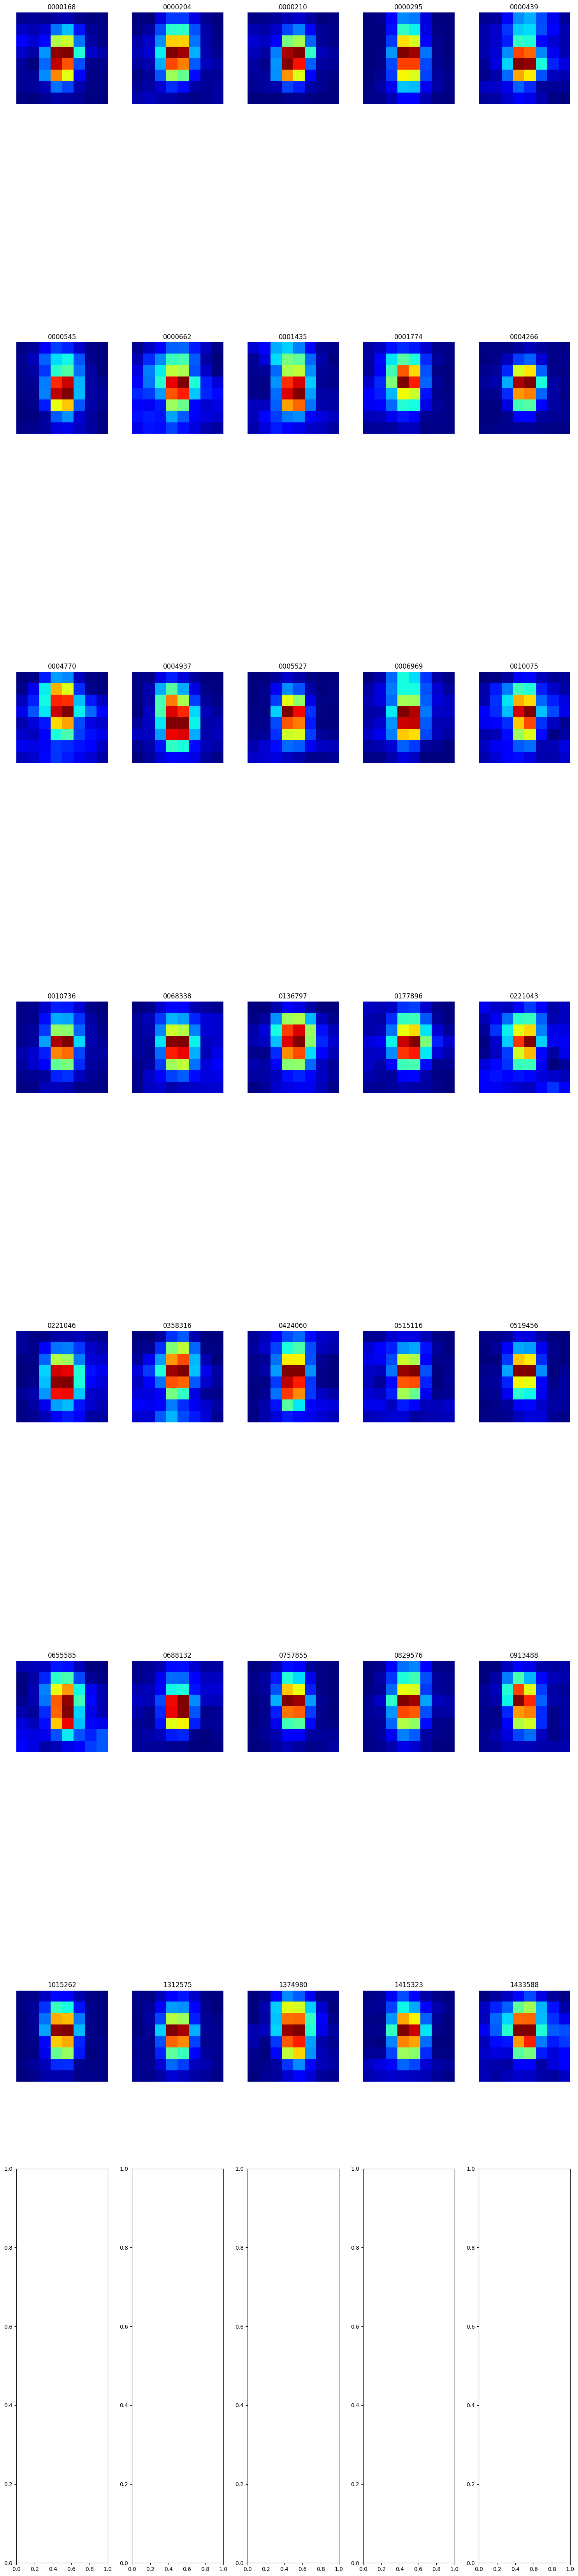

In [49]:
# Compute average heatmap per class
for cls in avg_heatmaps:
    # Convert list of heatmaps to proper shape [num_samples, H, W]
    heatmaps_list = []
    for hm in avg_heatmaps[cls]:
        if isinstance(hm, torch.Tensor):
            hm = hm.detach().cpu().squeeze(0).numpy()  # remove batch dim
        if hm.ndim == 3:
            hm = hm[0]  # take first channel if needed
        heatmaps_list.append(hm)
    avg_heatmaps[cls] = np.mean(heatmaps_list, axis=0)

# Plot class-wise average heatmaps
n_classes = len(avg_heatmaps)
fig, axes = plt.subplots(n_classes//5 + 1, 5, figsize=(15, n_classes*2))
axes = axes.flatten()
for i, (cls, heatmap) in enumerate(avg_heatmaps.items()):
    axes[i].imshow(heatmap, cmap="jet")
    axes[i].set_title(class_names[cls])
    axes[i].axis("off")
plt.tight_layout()
plt.show()


In [51]:
# -------------------------------
# Cell 7: Faithfulness Metrics
# -------------------------------

def compute_faithfulness(model, dataloader, cam_extractor, steps=20, max_images_per_class=10):
    model.eval()
    results = {cls: [] for cls in range(len(class_names))}
    
    for imgs, labels in tqdm(dataloader, desc="Faithfulness evaluation"):
        imgs, labels = imgs.to(device), labels.to(device)
        
        for img, label in zip(imgs, labels):
            if len(results[label.item()]) >= max_images_per_class:
                continue
            
            # Enable gradient for Grad-CAM
            img_tensor = img.unsqueeze(0).clone().detach().requires_grad_(True)
            
            # Forward pass
            out = model(img_tensor)
            pred = out.argmax(1).item()
            
            # Grad-CAM heatmap
            activation_map = cam_extractor(pred, out)[0].cpu().squeeze(0).numpy()
            heatmap = cv2.resize(activation_map, (img_tensor.shape[3], img_tensor.shape[2]))
            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
            flat_idx = np.argsort(-heatmap.flatten())
            
            img_np = img_tensor.squeeze(0).cpu().detach().permute(1,2,0).numpy()

            current_ins = np.zeros_like(img_np)
            current_del = img_np.copy()
            total_pixels = img_np.shape[0]*img_np.shape[1]
            step = total_pixels // steps
            
            insertion_scores, deletion_scores = [], []
            for i in range(0, total_pixels, step):
                idx = flat_idx[i:i+step]
                coords = np.unravel_index(idx, heatmap.shape)
                
                current_ins[coords] = img_np[coords]
                current_del[coords] = 0
                
                # Convert back to tensor
                ins_tensor = torch.tensor(current_ins).permute(2,0,1).unsqueeze(0).float().to(device)
                del_tensor = torch.tensor(current_del).permute(2,0,1).unsqueeze(0).float().to(device)
                
                # No grad needed for model outputs
                ins_conf = model(ins_tensor).softmax(1)[0, label].item()
                del_conf = model(del_tensor).softmax(1)[0, label].item()
                
                insertion_scores.append(ins_conf)
                deletion_scores.append(del_conf)
            
            insertion_auc = np.trapz(insertion_scores) / steps
            deletion_auc = np.trapz(deletion_scores) / steps
            conf_drop = insertion_scores[-1] - deletion_scores[-1]
            
            results[label.item()].append({
                "insertion_auc": insertion_auc,
                "deletion_auc": deletion_auc,
                "confidence_drop": conf_drop
            })
    
    # Class-wise averages
    class_avg_results = {}
    for cls, vals in results.items():
        if len(vals) == 0:
            continue
        class_avg_results[cls] = {
            "insertion_auc": np.mean([v["insertion_auc"] for v in vals]),
            "deletion_auc": np.mean([v["deletion_auc"] for v in vals]),
            "confidence_drop": np.mean([v["confidence_drop"] for v in vals])
        }
    return class_avg_results


# -------------------------------
# Example usage
# -------------------------------
faithfulness_results = compute_faithfulness(model, val_clean_loader, cam_extractor, steps=20, max_images_per_class=35)
for cls, metrics in faithfulness_results.items():
    print(f"Class {class_names[cls]}: Insertion AUC={metrics['insertion_auc']:.3f}, "
          f"Deletion AUC={metrics['deletion_auc']:.3f}, Confidence Drop={metrics['confidence_drop']:.3f}")


Faithfulness evaluation: 100%|██████████| 175/175 [1:05:06<00:00, 22.32s/it]

Class 0000168: Insertion AUC=0.633, Deletion AUC=0.197, Confidence Drop=0.887
Class 0000204: Insertion AUC=0.359, Deletion AUC=0.031, Confidence Drop=0.903
Class 0000210: Insertion AUC=0.551, Deletion AUC=0.121, Confidence Drop=0.898
Class 0000295: Insertion AUC=0.404, Deletion AUC=0.060, Confidence Drop=0.722
Class 0000439: Insertion AUC=0.423, Deletion AUC=0.138, Confidence Drop=0.871
Class 0000545: Insertion AUC=0.434, Deletion AUC=0.198, Confidence Drop=0.925
Class 0000662: Insertion AUC=0.514, Deletion AUC=0.259, Confidence Drop=0.849
Class 0001435: Insertion AUC=0.462, Deletion AUC=0.170, Confidence Drop=0.931
Class 0001774: Insertion AUC=0.328, Deletion AUC=0.088, Confidence Drop=0.796
Class 0004266: Insertion AUC=0.468, Deletion AUC=0.118, Confidence Drop=0.852
Class 0004770: Insertion AUC=0.442, Deletion AUC=0.135, Confidence Drop=0.914
Class 0004937: Insertion AUC=0.483, Deletion AUC=0.196, Confidence Drop=0.708
Class 0005527: Insertion AUC=0.462, Deletion AUC=0.092, Confiden